In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import os
from keras.layers import Input
from keras import layers, models
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.optimizers import *
from keras.preprocessing.image import load_img
from keras import initializers
from keras.callbacks import TensorBoard
import cv2
import pydot

filePath = "img_align_celeba/"
inputData = os.listdir(filePath)

def datagen(batchSize,filesList):
    img_shape = (64, 64, 3)
    while(True):
        files = np.random.choice(filesList,batchSize,replace=False)
        X_train = []
        for file in files:
            image = load_img(filePath + "/" + file)
            image = cv2.resize(np.asarray(image),(64,64),interpolation = cv2.INTER_CUBIC)
            image = image / 255.0
            X_train.append(image)
        X_train = np.array(X_train)
        yield X_train


Using TensorFlow backend.


In [2]:
# Hyper Parameters
randomDim = 100
batchSize = 5
epochs = 1

In [3]:
optimizer = Adam(lr=0.00007, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
img_shape     = (64, 64, 3)

def build_generator(img_shape, noise_shape = (100,)):
    '''
    noise_shape : the dimension of the input vector for the generator
    img_shape   : the dimension of the output
    '''
    ## latent variable as input
    input_noise = layers.Input(shape=noise_shape) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(128*8*8, activation="relu")(d)
    d = layers.Reshape((8,8,128))(d)
    
    d = layers.Conv2DTranspose(128, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_4")(d) ## 16,16


    d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_5")(d) ## 32,32
    
    d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_6")(d) ## 64,64
    
    img = layers.Conv2D( 3 , ( 1 , 1 ) , activation='sigmoid' , padding='same', name="final_block")(d) ## 32, 32
    model = models.Model(input_noise, img)
    model.summary() 
    return(model)

## Set the dimension of latent variables to be 100
noise_shape = (100,)

generator = build_generator(img_shape, noise_shape = noise_shape)

generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       65536     
_________________________________________________________________
block_4 (Conv2D)             (None, 16, 16, 64)        8256      
_________________________________________________________________
conv

In [4]:
#display(SVG(model_to_dot(generator).create(prog='dot', format='svg')))

In [6]:
def build_discriminator(img_shape,noutput=1):
    input_img = layers.Input(shape=img_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_img)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), name='block4_pool')(x)

    
    x         = layers.Flatten()(x)
    x         = layers.Dense(1024,      activation="relu")(x)
    out       = layers.Dense(noutput,   activation='sigmoid')(x)
    model     = models.Model(input_img, out)
    
    return model

discriminator  = build_discriminator(img_shape)
discriminator.compile(loss      = 'binary_crossentropy', 
                      optimizer = optimizer,
                      metrics   = ['accuracy'])

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 32)        896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 32)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
__________

In [8]:
z = layers.Input(shape=noise_shape)
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = models.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 3)         8594819   
_________________________________________________________________
model_3 (Model)              (None, 1)                 29780257  
Total params: 38,375,076
Trainable params: 8,594,819
Non-trainable params: 29,780,257
_________________________________________________________________


In [9]:
def plot_generated_images(imgs,batchSize,path_save=None,titleadd=""):
    fig = plt.figure(figsize=(40,batchSize))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,batchSize,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()

In [11]:
# Create the TensorBoard callback,
# which we will drive manually
tensorboard = TensorBoard(
  log_dir='log/run5',
  histogram_freq=0,
  batch_size=batchSize,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(combined)

  0%|          | 0/40519 [00:00<?, ?it/s]

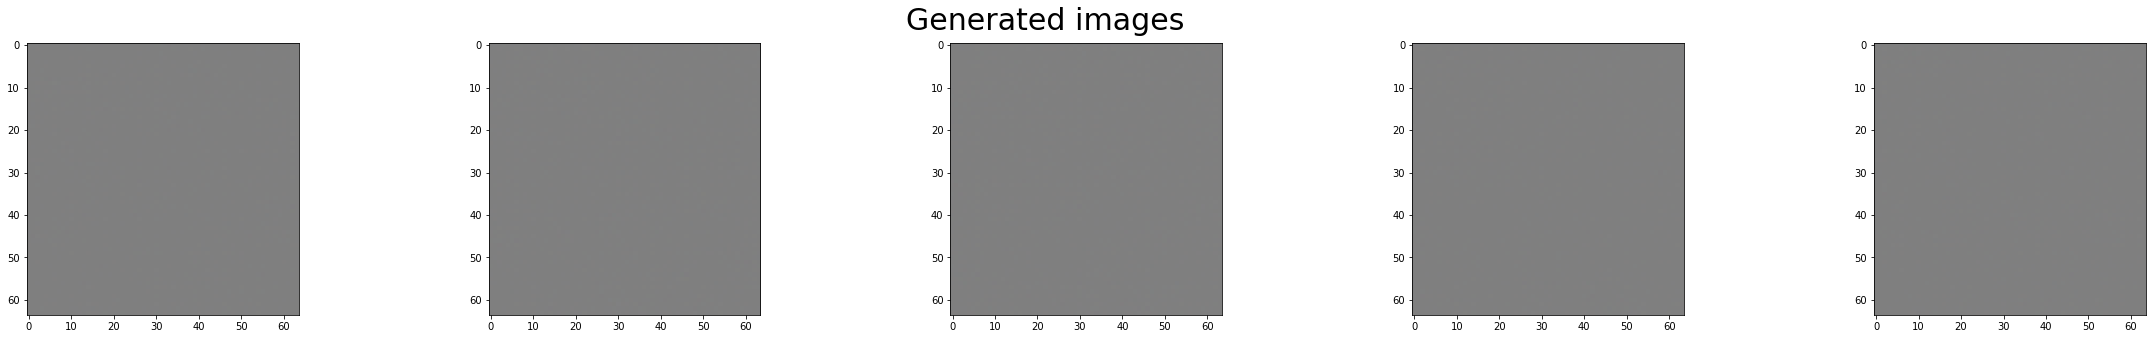

Instructions for updating:
Use tf.cast instead.


  0%|          | 100/40519 [02:50<18:36:34,  1.66s/it]

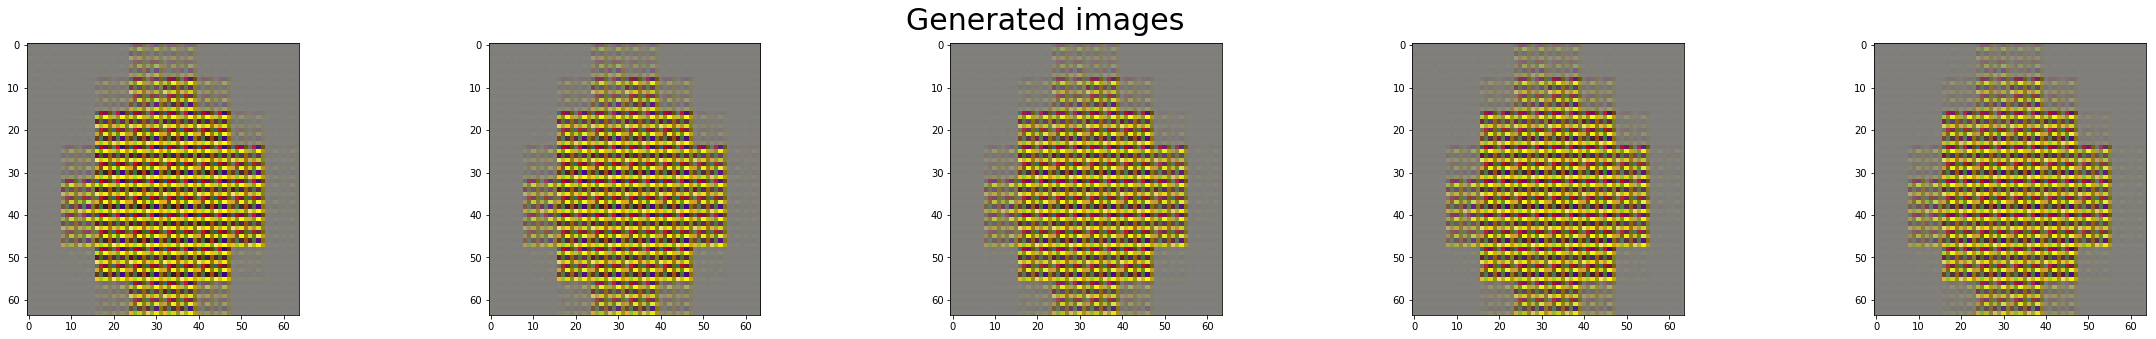

  0%|          | 200/40519 [05:33<19:32:02,  1.74s/it]

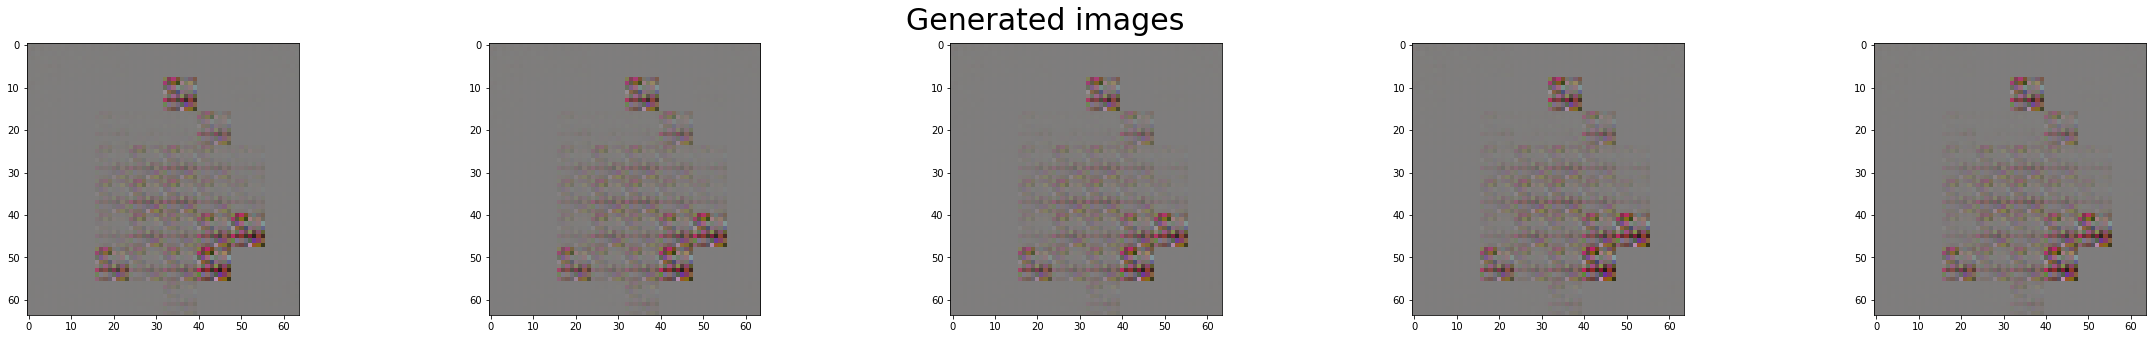

  1%|          | 300/40519 [08:14<17:40:35,  1.58s/it]

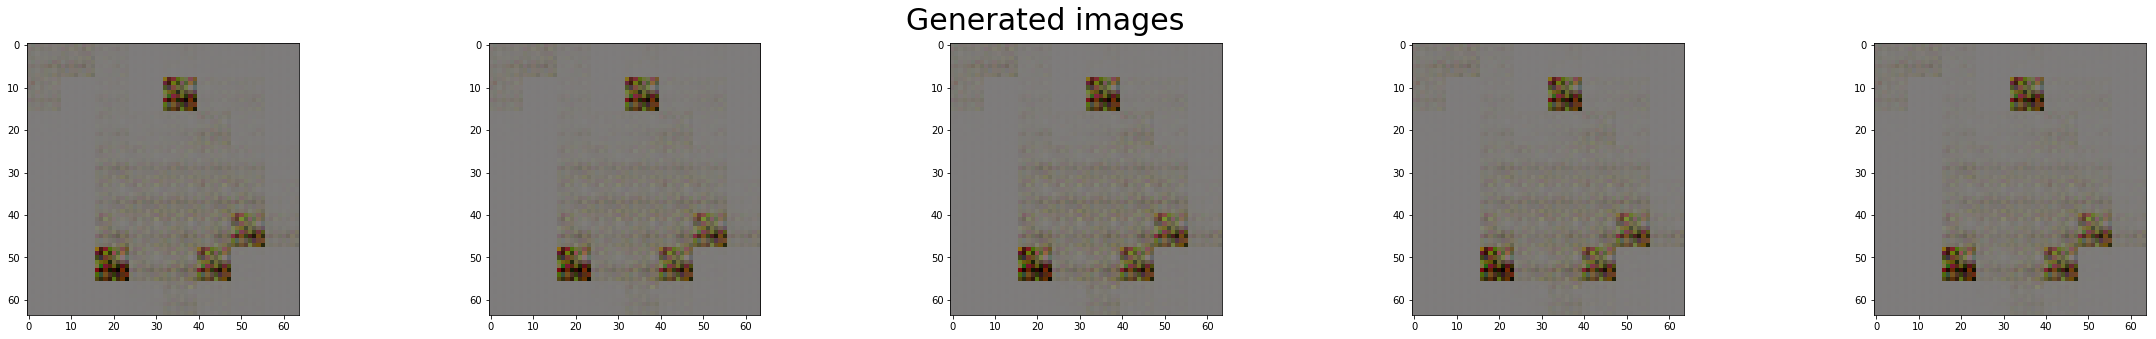

  1%|          | 400/40519 [10:55<18:53:07,  1.69s/it]

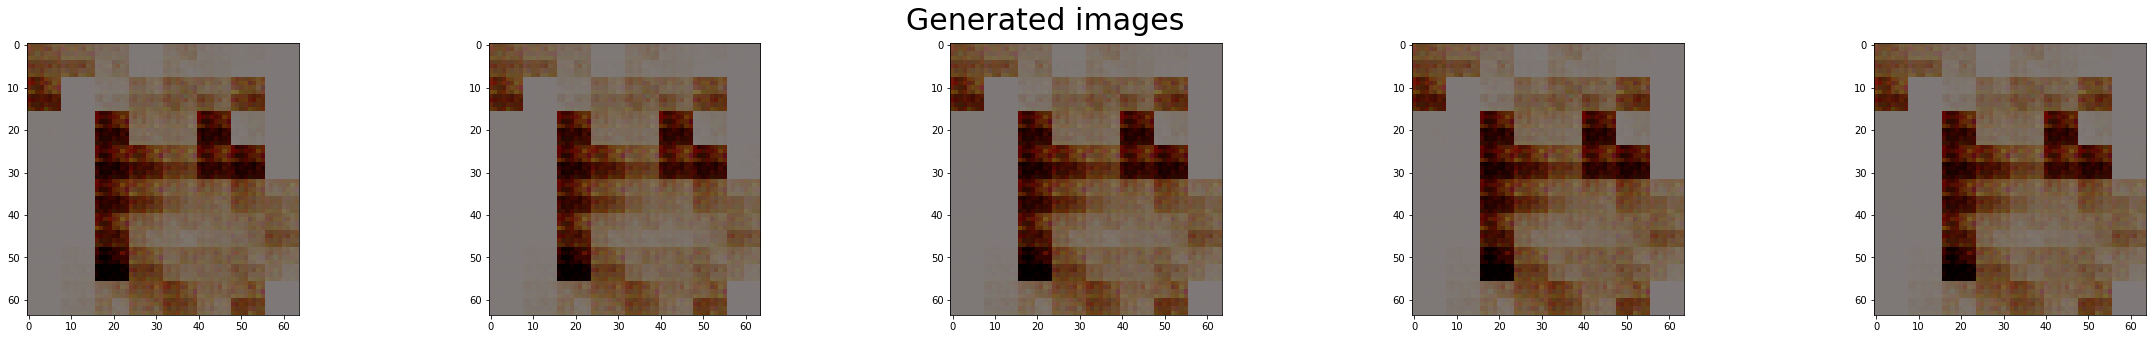

  1%|          | 483/40519 [13:07<17:26:34,  1.57s/it]

In [ ]:
def train(models,inputData,epochs, batchSize):
    combined, discriminator, generator = models
    #nlatent_dim = noise_plot.shape[1]
    #half_batch  = int(batchSize / 2)
    history = []
    datagenObj = datagen(batchSize,inputData)
    for epoch in range(epochs):
        for step in tqdm(range(len(inputData)//batchSize)):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            imgs = next(datagenObj)
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            #print(noise.shape)

            # Generate a half batch of new images
            gen_imgs = generator.predict(noise)

            if(step%100==0):
                plot_generated_images(gen_imgs,batchSize)

            # Train the discriminator q: better to mix them together?
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((batchSize, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batchSize, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            discriminator.trainable = False


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, size=[batchSize, randomDim])

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = (np.array([1] * batchSize)).reshape(batchSize,1)
            yGen = np.ones(batchSize)
            # Train the generator
            g_loss = combined.train_on_batch(noise, valid_y)

            history.append({"D":d_loss[0],"G":g_loss})
            tensorboard.on_epoch_end(step, {"D":d_loss[0],"G":g_loss})
            #print(history)
    tensorboard.on_train_end(None)    
    return history
      
models = combined, discriminator, generator
history = train(models,inputData,epochs,batchSize)

In [ ]:
imgs = next(datagenObj)

In [ ]:
fig = plt.figure(figsize=(40,10))
for i, img in enumerate(imgs):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(img)
fig.suptitle("Generated images "+titleadd,fontsize=30)